<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/Theory_experiment_mix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Determination of ST by NN using coords (rho,theta, volume, volt)

In [ ]:
# Use seaborn for pairplot
#!pip install seaborn
#!pip install talos
#!pip install -q  --no-deps tensorflow-addons~=0.7

In [1]:
!pip install lmfit
!pip install tensorflow_addons

     |████████████████████████████████| 307kB 7.9MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 256kB 13.6MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85265 sha256=c3410eb67b294048081c8f84c272fa1deb5e1f73da04f1d7b32feac3973a57b4
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.23-cp37-none-any.whl size=17419 sha256=c4784376e8ea4caa31491a835963e5f92964c90bf232157e464cb9bbb4841e2a
  Stored in directory: /root/.cache/pip/wheels/56/d6/43/4b5d8a9fd98b976031768673658c8b8d08dc9dcc0fa1907ad0
Successfully built lmfit asteval
     |████████████████████████████████| 706kB 8.8MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import pprint
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_addons as tfa

print(tf.__version__)


Instructions for updating:
non-resource variables are not supported in the long term
2.4.1


Run the next code box only if google drive is not mounted to colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If it **is** mounted continue from here on

Check the connection at google's **GPU**

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Or** check the connection at google's **TPU**

In [ ]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

### Get the data
First download the dataset!

**Option 1**: Upload files

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import io
csvfilename=str('TritonX100_conci_0.0100_all.csv')
input = pd.read_csv(io.BytesIO(uploaded[csvfilename]))
#input = pd.read_csv(csvfilename, sep="\t")
# Dataset is now stored in a Pandas Dataframe
input.shape

**Option 2**: Import files from drive

In [5]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/')

fileSDS1=pd.read_csv(str(path+'SDS/SDS_conci_0.01054_all.csv'), sep="\t")
fileSDS2=pd.read_csv(str(path+'SDS/SDS_conci_0.02108_all.csv'), sep='\t')
fileSDS3=pd.read_csv(str(path+'SDS/SDS_conci_0.04273_all.csv'), sep='\t')
fileSDS4=pd.read_csv(str(path+'SDS/SDS_conci_0.08828_all.csv'), sep="\t")
fileSDS5=pd.read_csv(str(path+'SDS/SDS_conci_0.25000_all.csv'), sep="\t")
fileSDS6=pd.read_csv(str(path+'SDS/SDS_conci_0.50000_all.csv'), sep="\t")
fileSDS7=pd.read_csv(str(path+'SDS/SDS_conci_0.75000_all.csv'), sep="\t")
fileSDS8=pd.read_csv(str(path+'SDS/SDS_conci_1.00000_all.csv'), sep="\t")
fileSDS9=pd.read_csv(str(path+'SDS/SDS_conci_1.25000_all.csv'), sep="\t")
fileSDS10=pd.read_csv(str(path+'SDS/SDS_conci_1.50000_all.csv'), sep="\t")
fileSDS11=pd.read_csv(str(path+'SDS/SDS_conci_2.00000_all.csv'), sep="\t")
fileSDS12=pd.read_csv(str(path+'SDS/SDS_conci_2.50000_all.csv'), sep="\t")
fileSDS13=pd.read_csv(str(path+'SDS/SDS_conci_3.00000_all.csv'), sep="\t")
fileSDS14=pd.read_csv(str(path+'SDS/SDS_conci_3.50000_all.csv'), sep="\t")
fileSDS15=pd.read_csv(str(path+'SDS/SDS_conci_4.00000_all.csv'), sep="\t")
fileSDS16=pd.read_csv(str(path+'SDS/SDS_conci_4.50000_all.csv'), sep="\t")
fileSDS17=pd.read_csv(str(path+'SDS/SDS_conci_5.50000_all.csv'), sep="\t")
fileSDS18=pd.read_csv(str(path+'SDS/SDS_conci_6.50000_all.csv'), sep="\t")
fileSDS19=pd.read_csv(str(path+'SDS/SDS_conci_7.50000_all.csv'), sep="\t")
fileSDS20=pd.read_csv(str(path+'SDS/SDS_conci_8.50000_all.csv'), sep="\t")
fileSDS21=pd.read_csv(str(path+'SDS/SDS_conci_24.75900_all.csv'), sep="\t")

fileTrit1=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00250_all.csv'), sep="\t")
fileTrit2=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00500_all.csv'), sep="\t")
fileTrit3=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00750_all.csv'), sep="\t")
fileTrit4=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01000_all.csv'), sep="\t")
fileTrit5=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01500_all.csv'), sep="\t")
fileTrit6=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02000_all.csv'), sep="\t")
fileTrit7=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02500_all.csv'), sep="\t")
fileTrit8=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.03500_all.csv'), sep="\t")
fileTrit9=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.05000_all.csv'), sep="\t")
fileTrit10=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.07500_all.csv'), sep="\t")
fileTrit11=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.10000_all.csv'), sep="\t")
fileTrit12=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.12500_all.csv'), sep="\t")
fileTrit13=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.15000_all.csv'), sep="\t")
fileTrit14=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.17500_all.csv'), sep="\t")
fileTrit15=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.20000_all.csv'), sep="\t")
fileTrit16=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.25000_all.csv'), sep="\t")
fileTrit17=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.30000_all.csv'), sep="\t")
fileTrit18=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.45000_all.csv'), sep="\t")
fileTrit19=pd.read_csv(str(path+'TritonX100/TritonX_conci_1.00000_all.csv'), sep="\t")
fileTrit20=pd.read_csv(str(path+'TritonX100/TritonX_conci_3.00000_all.csv'), sep="\t")
fileTrit21=pd.read_csv(str(path+'TritonX100/TritonX_conci_10.00000_all.csv'), sep="\t")

fileCTAB1=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00100_all.csv'), sep="\t")
fileCTAB2=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00200_all.csv'), sep="\t")
fileCTAB3=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00500_all.csv'), sep="\t")
fileCTAB4=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01000_all.csv'), sep="\t")
fileCTAB5=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01500_all.csv'), sep="\t")
fileCTAB6=pd.read_csv(str(path+'CTAB/CTAB_conci_0.05500_all.csv'), sep="\t")
fileCTAB7=pd.read_csv(str(path+'CTAB/CTAB_conci_0.10000_all.csv'), sep="\t")
fileCTAB8=pd.read_csv(str(path+'CTAB/CTAB_conci_0.15000_all.csv'), sep="\t")
fileCTAB9=pd.read_csv(str(path+'CTAB/CTAB_conci_0.20000_all.csv'), sep="\t")
fileCTAB10=pd.read_csv(str(path+'CTAB/CTAB_conci_0.25000_all.csv'), sep="\t")
fileCTAB11=pd.read_csv(str(path+'CTAB/CTAB_conci_0.30000_all.csv'), sep="\t")
fileCTAB12=pd.read_csv(str(path+'CTAB/CTAB_conci_0.40000_all.csv'), sep="\t")
fileCTAB13=pd.read_csv(str(path+'CTAB/CTAB_conci_0.50000_all.csv'), sep="\t")
fileCTAB14=pd.read_csv(str(path+'CTAB/CTAB_conci_0.60000_all.csv'), sep="\t")
fileCTAB15=pd.read_csv(str(path+'CTAB/CTAB_conci_0.70000_all.csv'), sep="\t")
fileCTAB16=pd.read_csv(str(path+'CTAB/CTAB_conci_0.80000_all.csv'), sep="\t")
fileCTAB17=pd.read_csv(str(path+'CTAB/CTAB_conci_0.85000_all.csv'), sep="\t")
fileCTAB18=pd.read_csv(str(path+'CTAB/CTAB_conci_0.90000_all.csv'), sep="\t")
fileCTAB19=pd.read_csv(str(path+'CTAB/CTAB_conci_1.00000_all.csv'), sep="\t")
fileCTAB20=pd.read_csv(str(path+'CTAB/CTAB_conci_5.00000_all.csv'), sep="\t")
fileCTAB21=pd.read_csv(str(path+'CTAB/CTAB_conci_13.15224_all.csv'), sep="\t")

#input=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7, fileSDS8, fileSDS9, fileSDS10, fileSDS11, 
                 #fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18, fileSDS19, fileSDS20, fileSDS21,
                # fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5, fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
                # fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21,
                # fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5, fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11,
                # fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])
# input=np.vstack([fileSDS5, fileSDS6, fileSDS7, fileSDS8, fileSDS9, fileSDS10, fileSDS13, fileSDS14,
#                  fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
#                  fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12,fileCTAB13, fileCTAB14])
# input.shape

#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)

In [6]:
# input=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7,fileSDS8, fileSDS9, fileSDS10, fileSDS11, 
#                  fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18,fileSDS19, fileSDS20, fileSDS21,
#                  fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5,  fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
#                  fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21,
#                  fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5,fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11,
#                  fileCTAB12, fileCTAB13, fileCTAB14, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])

# input=np.vstack([fileSDS1, fileSDS2, fileSDS3, fileSDS4, fileSDS5, fileSDS6, fileSDS7, fileSDS19, fileSDS20, fileSDS21,
#                  fileTrit1, fileTrit2, fileTrit3, fileTrit4, fileTrit5, fileTrit17, fileTrit18, fileTrit19, fileTrit20, fileTrit21,
#                  fileCTAB1, fileCTAB2, fileCTAB3, fileCTAB4, fileCTAB5, fileCTAB15, fileCTAB16, fileCTAB17, fileCTAB18, fileCTAB19, fileCTAB20, fileCTAB21])

input=np.vstack([fileSDS8, fileSDS9, fileSDS10, fileSDS11, fileSDS12, fileSDS13, fileSDS14, fileSDS15, fileSDS16, fileSDS17, fileSDS18,
                 fileTrit6, fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11, fileTrit12, fileTrit13, fileTrit14, fileTrit15, fileTrit16,
                 fileCTAB6, fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14])

# input=np.vstack([fileSDS8, fileSDS9, fileSDS10, fileSDS11, fileSDS12, fileSDS13,  fileSDS14, fileSDS15, fileSDS16, fileSDS17, 
#            fileTrit7, fileTrit8, fileTrit9, fileTrit10, fileTrit11,
#            fileTrit12, fileTrit13, fileTrit14, fileTrit15,  
#            fileCTAB7,fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, 
#            fileCTAB13])

# input=fileSDS8


In [11]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')  #900
column_names.append('width')  #901
column_names.append('volume')#902
column_names.append('R_sph')#903
column_names.append('volt')#904
column_names.append('Intensity')#905
column_names.append('time') #906
column_names.append('Power')#907
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x') #908
column_names.append('centre_y') #909
column_names.append('surfactant_conc') #910
column_names.append('Aspect_Ratio') #911
column_names.append('st') #912


#raw_dataset = pd.read_csv(csvfilename, sep="\t")
#raw_dataset.columns=column_names


raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

dataset.centre_y=-dataset.centre_y

# for i in range(300):
#  dataset.pop('rho_%d' %i)
for i in range(300):
  dataset.pop('phi_%d' %i)
# for i in range(300):
#  dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
# dataset.pop("volume")
dataset.pop("R_sph")
# dataset.pop('volt')
dataset.pop('Intensity')
dataset.pop('time')
dataset.pop('Power')
# dataset.pop('Ps')
#dataset.pop('Ps_err')
dataset.pop("centre_x")
dataset.pop("centre_y")
dataset.pop('surfactant_conc')
dataset.pop("Aspect_Ratio")


dataset.tail()

#We keep: volume	Power	centre_y	Aspect_Ratio	st

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,st
156655,0.822386,0.823070,0.823239,0.825227,0.825555,0.824092,0.821238,0.818078,0.817721,0.815634,0.813631,0.813586,0.810163,0.808581,0.807087,0.805554,0.797752,0.781719,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.688479,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.920926,-0.924124,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,8.92,38.500904
156656,0.822386,0.823070,0.823239,0.821416,0.821745,0.820293,0.817461,0.818078,0.813982,0.811903,0.813631,0.809883,0.810163,0.808581,0.807087,0.801922,0.797752,0.778296,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.685423,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.910221,-0.917701,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,8.92,38.499712
156657,0.822573,0.822786,0.822919,0.823070,0.823426,0.823852,0.822092,0.822457,0.823657,0.822217,0.818954,0.818713,0.813982,0.814799,0.809142,0.807522,0.805990,0.803189,0.800745,0.799657,0.798659,0.794785,0.785676,0.764862,0.759796,0.753192,0.748320,0.745215,0.743564,0.742796,0.716970,0.706155,0.701666,0.694930,0.692980,0.689382,0.674710,0.674743,0.667790,0.667122,...,-0.757954,-0.808650,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,8.92,38.503163
156658,0.816622,0.817186,0.817338,0.817902,0.819198,0.815699,0.817955,0.814972,0.815573,0.811311,0.809198,0.807171,0.807080,0.803610,0.802007,0.804156,0.798909,0.794612,0.778308,0.775011,0.768833,0.761904,0.760626,0.758179,0.757011,0.732146,0.721336,0.715399,0.710114,0.707627,0.702939,0.691228,0.687334,0.682313,0.681101,0.673345,0.667048,0.664653,0.662890,0.654785,...,-0.841003,-0.915101,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,8.92,38.493602
156659,0.816649,0.817338,0.817508,0.818125,0.815699,0.816030,0.814595,0.811797,0.812419,0.808375,0.806309,0.808049,0.804329,0.804638,0.799403,0.801596,0.796479,0.792391,0.773169,0.770040,0.764051,0.758632,0.757368,0.754950,0.753796,0.729203,0.718531,0.712674,0.707472,0.705017,0.7

### Selectively choose data with (almost) constant volume

In [ ]:
# new_input=[]
# vol_min=2.99
# vol_max=3.01
# for i in range(len(dataset)):
#   if dataset['volume'].iloc[i] >= vol_min and dataset['volume'].iloc[i] <= vol_max:
#     vol_ct_data=dataset.iloc[i, :]
#     new_input.append(vol_ct_data)
# new_input=np.asarray(new_input)
# new_input.shape

In [ ]:
# column_names=[]

# for i in range(300):
#   column_names.append('rho_%d' %i)
# for i in range(300):
#   column_names.append('theta_%d' %i)
# column_names.append('volume')
# column_names.append('R_sph')
# column_names.append('volt')
# column_names.append('st')

# new_dataset=pd.DataFrame(new_input, columns=column_names)
# new_dataset.pop('R_sph')
# new_dataset.tail()

In [ ]:
# plt.figure()
# sns.distplot(new_dataset['volt'])
# plt.xlabel('Voltage [V]')
# plt.ylabel('Count')

# plt.figure()
# sns.distplot(new_dataset['st'])
# plt.xlabel('Surface tension [mN/m]')
# plt.ylabel('Count')

In [ ]:
# #Drop volume if it's constant
# new_dataset.pop('volume')

### Calculate the acoustic pressure from the simple model

In [ ]:
# new_input=np.asarray(dataset)

In [ ]:
# # If no contour points were droped
# n_ST=603
# n_Rsph=602
# rho_i=0
# rho_f=300
# theta_i=300
# theta_f=600

In [ ]:
# from lmfit import Model, fit_report, Parameters

# def model_fit(th, Ps):
#     """
#     Express the model that will be used to fit the experimental data (simple approach).

#     Input parameters
#     ----------
#     dB:     deciBell
#     th:     angle theta
#     Returns
#     -------
#     Expression of fitting model.

#     """
#     rho=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)+R_sph
#     return rho


# data_Ps=[]
# Cg_air=1/101325 #Pa**(-1)
# k_o=2*np.pi*40/340 #mm^-1

# for i in range(len(new_input)):
#   gamma=new_input[i, n_ST]
#   R_sph=new_input[i, n_Rsph]
#   rho=new_input[i, rho_s, rho_e]
#   gmodel = Model(model_fit, nan_policy='omit')
    
#   fit_param = Parameters()
#   fit_param.add('Ps', value=700, min=10, max=4000)
  
#   result = gmodel.fit(rho, th=new_input[i, theta_i:theta_f], params=fit_param)         #rho_final, th: x and y to be evaluated, respectively
#   Ps=result.params['Ps'].value
#   data_Ps.append(Ps)
# data_Ps=np.asarray(data_Ps)

# plt.figure()
# plt.plot(data_Ps)
# plt.xlabel('Image')
# plt.ylabel('Acoustic pressure [Pa]')

#### Check the fitting of the simple model

In [ ]:
# i=100
# plt.figure()
# plt.plot(new_input[i, 300:600], rho, 'bo')
# plt.plot(new_input[i, 300:600], result.best_fit, 'r-', label='best fit')

In [ ]:
# column_names=[]

# for i in range(300):
#   column_names.append('rho_%d' %i)
# for i in range(300):
#   column_names.append('theta_%d' %i)
# column_names.append('volume')
# column_names.append('R_sph')
# column_names.append('volt')
# column_names.append('st')

# new_dataset=pd.DataFrame(new_input, columns=column_names)

In [ ]:
# # #Add the calclulated Ps values to the new_dataset dataframe
# new_dataset['Ps']=data_Ps

# #Drop the features that we don't have in the saved model
# new_dataset.pop('R_sph')
# new_dataset.pop('volt')
# # new_dataset.pop('volume')
# new_dataset.tail()

### Keep Ps values within a specific range

In [ ]:
# newer_input=[]
# Ps_min=1500
# Ps_max=2100
# for i in range(len(new_dataset)):
#   if new_dataset['Ps'].iloc[i] >= Ps_min and new_dataset['Ps'].iloc[i] <= Ps_max:
#     Ps_range=new_dataset.iloc[i, :]
#     newer_input.append(Ps_range)
# newer_input=np.asarray(newer_input)

# newer_input.shape

In [ ]:
# plt.figure()
# plt.plot(newer_input[:, 601])
# plt.ylabel('Acoustic pressure [Pa]')
# plt.xlabel('droplet')

### Store values in new DataFrame

In [ ]:
# column_names=[]

# for i in range(300):
#   column_names.append('rho_%d' %i)
# for i in range(300):
#   column_names.append('theta_%d' %i)
# # column_names.append('volume')
# column_names.append('st')
# column_names.append('Ps')

# new_df=pd.DataFrame(newer_input, columns=column_names)

# #Drop ST:
# new_df.pop('st')

### Drop contour points

In [12]:
# If we want to drop 150 datapoints then n= 299 

# If we want to drop 125 datapoints then n= 250

n=250
for i in range(0, n, 2):
  dataset.pop('theta_%d' %i)

for i in range(0,n, 2):
  dataset.pop('rho_%d' %i)
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,st
156655,0.823070,0.825227,0.824092,0.818078,0.815634,0.813586,0.808581,0.805554,0.781719,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.688479,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.628819,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.920926,-0.924124,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,8.92,38.500904
156656,0.823070,0.821416,0.820293,0.818078,0.811903,0.809883,0.808581,0.801922,0.778296,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.685423,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.625050,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.910221,-0.917701,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,8.92,38.499712
156657,0.822786,0.823070,0.823852,0.822457,0.822217,0.818713,0.814799,0.807522,0.803189,0.799657,0.794785,0.764862,0.753192,0.745215,0.742796,0.706155,0.694930,0.689382,0.674743,0.667122,0.653507,0.650905,0.638653,0.635265,0.634700,0.627852,0.628819,0.623878,0.622282,0.624406,0.623456,0.621623,0.622646,0.624816,0.624101,0.628132,0.629016,0.632727,0.635035,0.638527,...,-0.757954,-0.808650,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,8.92,38.503163
156658,0.817186,0.817902,0.815699,0.814972,0.811311,0.807171,0.803610,0.804156,0.794612,0.775011,0.761904,0.758179,0.732146,0.715399,0.707627,0.691228,0.682313,0.673345,0.664653,0.654785,0.649896,0.645412,0.644084,0.638701,0.636487,0.632267,0.634242,0.628821,0.627307,0.627517,0.628333,0.628368,0.629902,0.632914,0.631978,0.634991,0.639480,0.638094,0.640839,0.646340,...,-0.841003,-0.915101,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,8.92,38.493602
156659,0.817338,0.818125,0.816030,0.811797,0.808375,0.808049,0.804638,0.801596,0.792391,0.770040,0.758632,0.754950,0.729203,0.712674,0.705017,0.688896,0.680123,0.671387,0.662890,0.653219,0.648498,0.644141,0.642902,0.637784,0.635728,0.631642,0.633688,0.628565,0.627354,0.62763

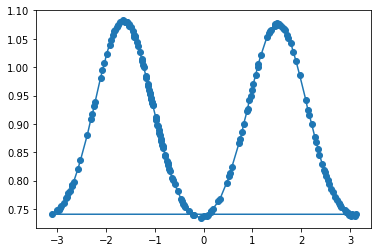

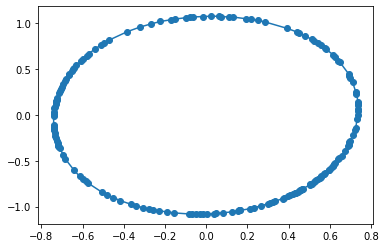

In [13]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#Check that the drop contour is still well defined!

# For 150 contour datapoints:
# plt.figure()
# plt.plot(dataset.iloc[600, 150:300], dataset.iloc[600, 0:150])

# x, y=pol2cart(dataset.iloc[n, 0:150].values, dataset.iloc[n, 150:300].values)

# plt.figure()
# plt.plot(x, y, '-o')

############################################################################################

# For 175 contour datapoints:
n=200
plt.figure()
plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')

x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)

plt.figure()
plt.plot(x, y, '-o')

### Test saved model

In [25]:
ST_values=np.asarray(dataset.st)
ST_values

array([65.63691505, 65.63626423, 65.63824868, ..., 38.50316303,
       38.49360226, 38.49148659])

In [26]:
n_dataset=dataset.copy()

n_dataset.pop('st')

dataset_name=n_dataset

stats_input_df=dataset_name.describe()
stats_input_df=stats_input_df.transpose()
stats_input_df.tail()

,count,mean,std,min,25%,50%,75%,max
theta_297,156660.0,-1.525113,0.025350,-1.564507,-1.544731,-1.531291,-1.510264,-1.384236
theta_298,156660.0,-1.539287,0.022726,-1.567868,-1.556932,-1.546240,-1.526521,-1.436773
theta_299,156660.0,-1.557540,0.013586,-1.570796,-1.568179,-1.562191,-1.550849,-1.464479
volume,156660.0,2.710796,1.057077,0.431143,1.919141,2.626217,3.394665,6.006597
volt,156660.0,8.059574,0.880276,6.600000,7.320000,7.930000,8.760000,10.000000


### Normalize the input features

In [27]:
def norm_test(x):
  return (x - stats_input_df['mean']) / stats_input_df['std']

norm_input_array=norm_test(dataset_name)


### Test the saved model on the input features

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                4942      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 5,023
Trainable params: 5,023
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


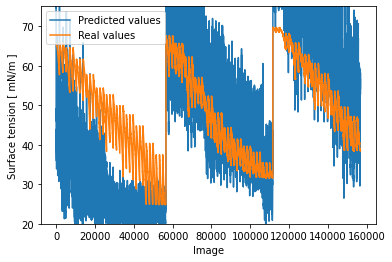

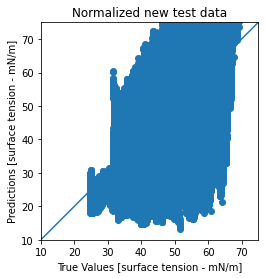

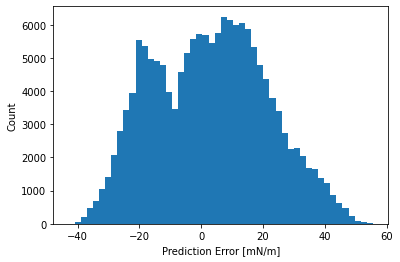

In [28]:
#Import model from drive
folder=str('theory_experiment_mix/')
filename=str('All_surf_all_vary_175points_trial_1.h5')
model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)
model.summary()

prediction=model.predict(norm_input_array).flatten()
true_values=ST_values

plt.figure()
plt.xlabel('Image')
plt.ylabel('Surface tension [ mN/m ]')
plt.ylim(20, 75)
plt.plot(prediction, label='Predicted values')
plt.plot(true_values, label='Real values')
plt.legend()

plt.figure()
plt.scatter(true_values, prediction)
plt.title('Normalized new test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = prediction - true_values
plt.figure()
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 30)
plt.show()


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [29]:
train_dataset = dataset.sample(frac=0.8,random_state=1)
test_dataset = dataset.drop(train_dataset.index)

Also look at the overall statistics:

In [30]:
train_stats = train_dataset.describe()
train_stats.pop("st")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
rho_1,125328.0,0.933976,0.136238,0.506855,0.842662,0.941017,1.031875,1.320479
rho_3,125328.0,0.934109,0.136166,0.505261,0.842832,0.941258,1.032001,1.321225
rho_5,125328.0,0.933477,0.136013,0.503873,0.842629,0.940476,1.031364,1.322952
rho_7,125328.0,0.931852,0.135856,0.501162,0.841190,0.938576,1.029808,1.322168
rho_9,125328.0,0.929094,0.135869,0.497544,0.838338,0.934857,1.027460,1.313794
...,...,...,...,...,...,...,...,...
theta_297,125328.0,-1.525129,0.025322,-1.564507,-1.544731,-1.531282,-1.510323,-1.384236
theta_298,125328.0,-1.539312,0.022684,-1.567864,-1.556908,-1.546227,-1.526577,-1.436773
theta_299,125328.0,-1.557566,0.013556,-1.570796,-1.568179,-1.562194,-1.550943,-1.464479
volume,125328.0,2.712248,1.057960,0.431143,1.920658,2.625074,3.396813,6.006597


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [34]:
train_labels = train_dataset.pop('st')
test_labels = test_dataset.pop('st')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

In [35]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#Check pre normalization and after normalization
first = np.array(train_dataset[:1])
with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', normed_train_data[:1])

First example: [[ 1.1   1.1   1.1   1.09  1.09  1.09  1.09  1.09  1.08  1.08  1.08  1.07
   1.06  1.05  1.04  1.03  1.02  1.01  0.99  0.99  0.97  0.96  0.94  0.93
   0.92  0.91  0.9   0.89  0.88  0.88  0.86  0.86  0.86  0.86  0.86  0.86
   0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.85  0.86  0.86
   0.86  0.87  0.87  0.88  0.88  0.88  0.88  0.89  0.9   0.91  0.91  0.91
   0.93  0.94  0.96  0.97  0.97  1.    1.01  1.02  1.02  1.03  1.05  1.05
   1.07  1.07  1.07  1.08  1.08  1.09  1.09  1.09  1.09  1.1   1.09  1.09
   1.09  1.09  1.09  1.08  1.08  1.08  1.07  1.06  1.05  1.04  1.04  1.03
   1.03  1.03  1.02  1.    0.99  0.98  0.97  0.96  0.95  0.93  0.92  0.91
   0.89  0.89  0.88  0.88  0.86  0.86  0.86  0.85  0.85  0.85  0.85  0.85
   0.85  0.85  0.86  0.86  0.87  0.87  0.87  0.87  0.87  0.89  0.9   0.92
   0.92  0.92  0.92  0.92  0.92  0.93  0.93  0.93  0.94  0.96  0.96  0.97
   0.98  0.98  0.99  0.99  1.    1.02  1.02  1.03  1.03  1.03  1.04  1.05
   1.05  1.05  1.06  1.

## The model

In [36]:
from tensorflow.keras.models import load_model

del model 
folder=str('theory_experiment_mix/')
model_name=str('All_surf_all_vary_175points_trial_1.h5')


model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [37]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 55 == 0: print('')
    print('.', end='')
    


EPOCHS = 200


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=0, mode='auto')


history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



.......................................................
.......................................................
.......................................................
...................................

Visualize the model's training progress using the stats stored in the `history` object.

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
195,26.484266,3.976285,26.484264,27.208591,4.062644,27.208590,195
196,26.470141,3.976022,26.470129,27.117386,4.058303,27.117373,196
197,26.471445,3.976367,26.471436,27.029223,4.011618,27.029219,197
198,26.461428,3.972670,26.461456,27.142366,4.026211,27.142384,198
199,26.446508,3.973809,26.446508,26.949933,4.015257,26.949934,199


Let's automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

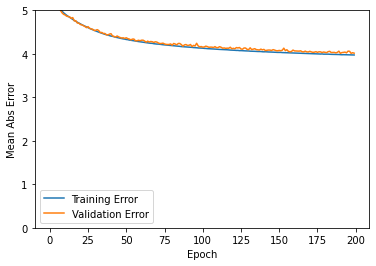

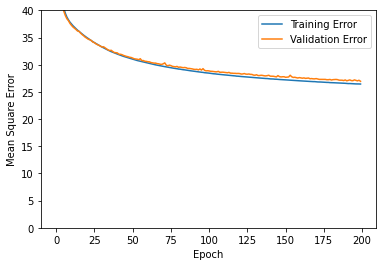

In [43]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Validation Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Validation Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()


plot_history(history)

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [40]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))
# keras.metrics.accuracy(normed_test_data, test_labels)

Testing set Mean Abs Error:  4.01 mN/m


### Make predictions

Finally, predict volume values using data in the testing set:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


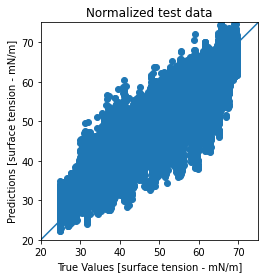

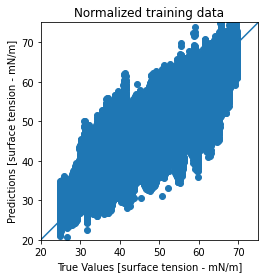

In [41]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([20,75])
plt.ylim([20,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([20,75])
plt.ylim([20,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


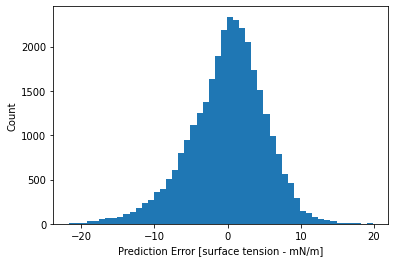

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [surface tension - mN/m]")
_ = plt.ylabel("Count")
# plt.xlim(-20, 20)
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('Experimental_surfactants/')
filename=str('TritonX_all_vary_175points_trial_2.h5')
!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

The SavedModel format is a directory containing a protobuf binary and a Tensorflow checkpoint. Inspect the saved model directory:

In [ ]:
# DropLev_st_prediction_model directory
#!ls content/drive/My Drive/DropLev/MachineLearningModels

# Contains an assets folder, saved_model.pb, and variables folder.
#!ls content/drive/My Drive/DropLev/MachineLearningModels/SDS_1.h5

Saving the model in a **HDF5** format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
#model.save('content/drive/My Drive/DropLev/MachineLearningModels/'+filename) 